In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
train_loc = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/"
val_loc = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/validation/"

In [39]:
trainset = datasets.ImageFolder(train_loc, transform = transforms.Compose(
[
#     transforms.Grayscale(),
transforms.Resize((512,512)),
transforms.ToTensor()]
))

valset = datasets.ImageFolder(val_loc, transform = transforms.Compose(
[
#     transforms.Grayscale(),
transforms.Resize((512,512)),
transforms.ToTensor()]
))

In [40]:
train_loader = DataLoader(dataset = trainset, batch_size = 64, shuffle = True)

In [36]:
val_loader = DataLoader(dataset = valset, batch_size = 64, shuffle = True)

### Calculation of mean and std

In [41]:
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0,0,0
    
    for data,_ in tqdm(loader):
        channels_sum += torch.mean(data, dim = [0,2,3])
        channels_squared_sum += torch.mean(data**2, dim = [0,2,3])
        num_batches += 1
        
    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches - mean**2)**0.5
    
    return mean, std

In [42]:
mean, std = get_mean_std(train_loader)

  0%|          | 0/281 [00:00<?, ?it/s]

In [37]:
print(mean, std)

tensor([0.5027]) tensor([0.2466])


In [38]:
mean, std = get_mean_std(val_loader)
print(mean, std)

  0%|          | 0/54 [00:00<?, ?it/s]

tensor([0.5020, 0.5020, 0.5021]) tensor([0.2460, 0.2460, 0.2460])


### Baseline Solution

In [7]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from tqdm.autonotebook import tqdm
import torch
import os

In [8]:
def show_image(image, label, get_denormalized = True):
    
    image = image.permute(1,2,0) #??
    mean = torch.FloatTensor([0.5027,0.5027,0.5027])
    std = torch.FloatTensor([0.2466,0.2466,0.2466])
    
    if get_denormalized == True:
        image  = (image*std) + mean
        image  = np.clip(image, 0, 1)
        plt.imshow(image, cmap = 'gray')
        plt.title(label)
        
    else:
        plt.imshow(image, cmap = 'gray')
        plt.title(label)
        
def show_grid(image, title = None): #??
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.5027,0.5027,0.5027])
    std = torch.FloatTensor([0.2466,0.2466,0.2466])
    image  = (image*std) + mean
    image  = np.clip(image, 0, 1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image, cmap = 'gray')
    if title != None:
        plt.title(title)
        
def accuray(y_pred,y_true):
    y_pred = F.softmax(y_pred, dim =1)
    top_p, top_class = y_pred.topk(1,dim =1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

def view_classify(image, ps, label):
    class_name = ['covid', 'normal', 'pneumonia']
    classes = np.array(class_name)
    
    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0) #??
    mean = torch.FloatTensor([0.5027,0.5027,0.5027])
    std = torch.FloatTensor([0.2466,0.2466,0.2466])
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None


    
        

In [9]:
class CFG:
    epochs = 20
    lr = 0.001
    batch_size = 16
    img_size = 224
    
    model_name = 'tf_efficientnet_b4_ns'
    
    train_path = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/"
    validate_path = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/validation/"
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print(f"We are on: {device}")
    
    

We are on: cuda


In [15]:
from torchvision import transforms as T, datasets

In [16]:
train_transform = T.Compose([
#     T.Grayscale(),
    T.Resize(size = (CFG.img_size, CFG.img_size)), 
    T.RandomRotation(degrees = (-20,20)),
    T.ToTensor(),
    T.Normalize([0.5027,0.5027,0.5027], [0.2466,0.2466,0.2466])
]
)

validate_transform = T.Compose([
#     T.Grayscale(),
    T.Resize(size = (CFG.img_size, CFG.img_size)), 
    T.ToTensor(),
    T.Normalize([0.5027,0.5027,0.5027], [0.2466,0.2466,0.2466])
]
)



In [17]:
trainset = datasets.ImageFolder(CFG.train_path, transform = train_transform)
print("Trainset Size:  {}".format(len(trainset)))

Trainset Size:  17958


In [18]:
validateset = datasets.ImageFolder(CFG.validate_path, transform = validate_transform)
print("Trainset Size:  {}".format(len(validateset)))

Trainset Size:  3432


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


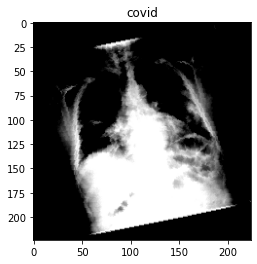

In [19]:
img, label = trainset[20]
show_image(img,trainset.classes[label], get_denormalized=False)

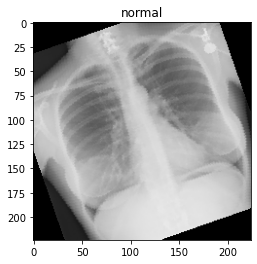

In [20]:
img, label = trainset[8000]
show_image(img,trainset.classes[label], get_denormalized=True)

In [21]:
from torch.utils.data import DataLoader

In [22]:
trainloader = DataLoader(trainset, batch_size = CFG.batch_size, shuffle = True)
validationloader = DataLoader(validateset, batch_size = CFG.batch_size, shuffle = False)
print("No. of batches in trainloader:{}".format(len(trainloader)))
print("No. of Total examples:{}".format(len(trainloader.dataset)))
print("No. of batches in validationloader:{}".format(len(validationloader)))
print("No. of Total examples:{}".format(len(validationloader.dataset)))

No. of batches in trainloader:1123
No. of Total examples:17958
No. of batches in validationloader:215
No. of Total examples:3432


In [23]:
!pip install timm

You should consider upgrading via the '/home/brats/miniconda3/envs/brats/bin/python -m pip install --upgrade pip' command.


In [24]:
from torch import nn
import torch.nn.functional as F
import timm

In [25]:
model = timm.create_model(CFG.model_name, pretrained=True)

In [27]:
for param in model.parameters():
    param.requires_grad=False
    
model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625), #1792 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=3), 
)


In [28]:
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [29]:
class CovidTrainer():
    def __init__(self, criterion = None, optimizer = None, schedular = None):
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
        
    def train_batch_loop(self, model, trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images, labels in tqdm(trainloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits, labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            
            train_acc += accuray(logits, labels)
            
        return train_loss/len(trainloader), train_acc/len(trainloader)
    
    def valid_batch_loop(self, model, validloader):
        
        valid_loss = 0.0
        valid_acc  = 0.0
        
        for images, labels in tqdm(validloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits, labels)
            
            valid_loss += loss.item()
            valid_acc  += accuray(logits, labels)
            
        return valid_loss/len(trainloader), valid_acc/len(trainloader)
    
    
    def fit(self, model, trainloader, validloader, epochs):
        
        valid_min_loss = np.Inf
        
        for i in range(epochs):
            
            model.train()
            avg_train_loss, avg_train_acc = self.train_batch_loop(model, trainloader)
            
            model.eval()
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader)
            
            
            if avg_valid_loss <= valid_min_loss:
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'covid_baseline.pt')
                
                valid_min_loss = avg_valid_loss
                
                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))
                
                
                
                
            
            
            
            
            
            
            
        
        

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CFG.lr)

trainer = CovidTrainer(criterion,optimizer)
trainer.fit(model.to(device),trainloader,validationloader,epochs = CFG.epochs)


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.1326760933771796
Epoch : 1 Train Loss : 0.708040 Train Acc : 0.701265
Epoch : 1 Valid Loss : 0.132676 Valid Acc : 0.136409


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.626295 Train Acc : 0.747329
Epoch : 2 Valid Loss : 0.134753 Valid Acc : 0.138635


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Valid_loss decreased 0.1326760933771796 --> 0.12672732334554143
Epoch : 3 Train Loss : 0.588769 Train Acc : 0.762615
Epoch : 3 Valid Loss : 0.126727 Valid Acc : 0.139860


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Valid_loss decreased 0.12672732334554143 --> 0.10348935551337653
Epoch : 4 Train Loss : 0.571171 Train Acc : 0.770796
Epoch : 4 Valid Loss : 0.103489 Valid Acc : 0.150935


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Valid_loss decreased 0.10348935551337653 --> 0.10073026608035486
Epoch : 5 Train Loss : 0.549567 Train Acc : 0.780332
Epoch : 5 Valid Loss : 0.100730 Valid Acc : 0.149711


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Valid_loss decreased 0.10073026608035486 --> 0.1001815327035988
Epoch : 6 Train Loss : 0.540721 Train Acc : 0.786380
Epoch : 6 Valid Loss : 0.100182 Valid Acc : 0.151547


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.524251 Train Acc : 0.793318
Epoch : 7 Valid Loss : 0.104780 Valid Acc : 0.148542


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.513236 Train Acc : 0.798086
Epoch : 8 Valid Loss : 0.102611 Valid Acc : 0.152048


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.518929 Train Acc : 0.794579
Epoch : 9 Valid Loss : 0.101930 Valid Acc : 0.149989


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.509705 Train Acc : 0.800553
Epoch : 10 Valid Loss : 0.101588 Valid Acc : 0.150879


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Valid_loss decreased 0.1001815327035988 --> 0.09993398234327776
Epoch : 11 Train Loss : 0.504746 Train Acc : 0.804226
Epoch : 11 Valid Loss : 0.099934 Valid Acc : 0.152883


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Valid_loss decreased 0.09993398234327776 --> 0.09838146747538583
Epoch : 12 Train Loss : 0.497260 Train Acc : 0.804541
Epoch : 12 Valid Loss : 0.098381 Valid Acc : 0.154998


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.486157 Train Acc : 0.811072
Epoch : 13 Valid Loss : 0.100474 Valid Acc : 0.152271


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Valid_loss decreased 0.09838146747538583 --> 0.09388507145622003
Epoch : 14 Train Loss : 0.489374 Train Acc : 0.804430
Epoch : 14 Valid Loss : 0.093885 Valid Acc : 0.154664


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Valid_loss decreased 0.09388507145622003 --> 0.09193503587296895
Epoch : 15 Train Loss : 0.485757 Train Acc : 0.806953
Epoch : 15 Valid Loss : 0.091935 Valid Acc : 0.154998


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.483078 Train Acc : 0.811127
Epoch : 16 Valid Loss : 0.101399 Valid Acc : 0.150045


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Valid_loss decreased 0.09193503587296895 --> 0.08992860891515404
Epoch : 17 Train Loss : 0.477619 Train Acc : 0.813966
Epoch : 17 Valid Loss : 0.089929 Valid Acc : 0.155276


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.475919 Train Acc : 0.815524
Epoch : 18 Valid Loss : 0.101376 Valid Acc : 0.151046


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.465481 Train Acc : 0.814726
Epoch : 19 Valid Loss : 0.092021 Valid Acc : 0.156834


  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.475523 Train Acc : 0.813928
Epoch : 20 Valid Loss : 0.092747 Valid Acc : 0.154330


In [31]:
#WTF